#### Build the Neural Network

In [7]:
import os

import pylab as p
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

#### Get Device for Training

In [8]:
# 定义设备 - 支持 macOS
device = torch.device(
    "mps" if torch.backends.mps.is_available() else  
    "cuda" if torch.cuda.is_available() else       
    "cpu"                                          
)
print(f"Using device: {device}")

Using device: mps


In [21]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        # 神经网络层堆栈
        self.linear_relu_stack = nn.Sequential(
            # 512：这是输出特征的维度。该线性层会将 784 维的输入映射到 512 维的输出空间。
            nn.Linear(28*28,512),#28*28 表示输入数据有 784 个特征
            nn.ReLU(),
            nn.Linear(512,512),
            nn.ReLU(),
            nn.Linear(512,10),   
        )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
            

In [22]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [27]:
from torchviz import make_dot


# 创建模型和示例输入
model = NeuralNetwork()
x = torch.randn(1, 1, 28, 28)  # 示例输入
y = model(x)

# 生成可视化图
# 也可以指定地址
# make_dot(...).render("/Users/acw/路径/network", format="png")
dot = make_dot(y, params=dict(model.named_parameters()))
dot.render("network", format="png")  # 保存为PNG文件


'network.png'

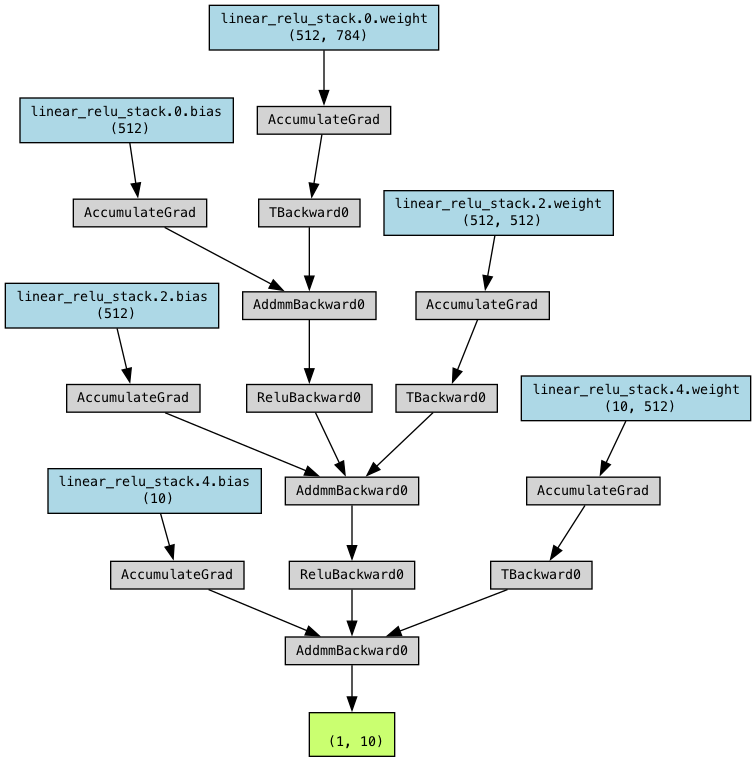

In [28]:
from IPython.display import Image
Image(filename="network.png")

In [25]:
import shutil
print(shutil.which("dot"))

/opt/homebrew/bin/dot


In [30]:
# 确保模型在正确的设备上
model = NeuralNetwork().to(device)
print(f"Model device: {next(model.parameters()).device}")
# 创建输入数据
X = torch.rand(1, 28, 28, device=device)
print(f"Input device: {X.device}")
# 进行预测
logits = model(X)
# dim=1 表示在类别维度上应用Softmax，使得所有类别的概率之和为1
pred_probab = nn.Softmax(dim=1)(logits)
# 使用 argmax(1) 找到概率最高的类别索引
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Model device: mps:0
Input device: mps:0
Predicted class: tensor([5], device='mps:0')


##### Model Layers
让我们分解一下 FashionMNIST 模型的各个层。为了说明这一点，我们将取一个包含 3 张 28x28 大小图像的小批量样本，并观察它在网络中传递时会发生什么。

In [31]:
input_image = torch.rand(3,28,28)
print(input_image.size())

torch.Size([3, 28, 28])


In [32]:
flattn = nn.Flatten()
flat_image = flattn(input_image)
print(flat_image.size())

torch.Size([3, 784])


##### nn.Linear
> 线性层 是一个使用其存储的权重和偏差对输入应用线性变换的模块。
The linear layer is a module that applies a linear transformation on the input using its stored weights and biases.

In [34]:
layer1 = nn.Linear(in_features=28*28, out_features=20)
hidden1 = layer1(flat_image)
print(hidden1.size())

torch.Size([3, 20])


##### nn.ReLU

In [37]:
print(f"Before ReLU: {hidden1}\n\n")
hidden1 = nn.ReLU()(hidden1)
print("-----------------------------------------------------------------")
print(f"After ReLU: {hidden1}")

Before ReLU: tensor([[0.0789, 0.1061, 0.0000, 0.8798, 0.1539, 0.0000, 0.5458, 0.2198, 0.0000,
         0.1134, 0.1291, 0.4758, 0.0000, 0.2409, 0.0000, 0.0000, 0.4054, 0.0000,
         0.0000, 0.0000],
        [0.1829, 0.2506, 0.0000, 0.6886, 0.1120, 0.0000, 0.5218, 0.1391, 0.0000,
         0.0000, 0.4643, 0.4333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0407, 0.0000,
         0.0486, 0.0000],
        [0.0000, 0.4053, 0.0000, 0.4457, 0.4632, 0.0000, 0.4229, 0.0000, 0.0000,
         0.0065, 0.6620, 0.1103, 0.0000, 0.0000, 0.0000, 0.0000, 0.4857, 0.0000,
         0.0000, 0.0000]], grad_fn=<ReluBackward0>)


-----------------------------------------------------------------
After ReLU: tensor([[0.0789, 0.1061, 0.0000, 0.8798, 0.1539, 0.0000, 0.5458, 0.2198, 0.0000,
         0.1134, 0.1291, 0.4758, 0.0000, 0.2409, 0.0000, 0.0000, 0.4054, 0.0000,
         0.0000, 0.0000],
        [0.1829, 0.2506, 0.0000, 0.6886, 0.1120, 0.0000, 0.5218, 0.1391, 0.0000,
         0.0000, 0.4643, 0.4333, 0.0000, 0.0000,

### nn.Sequential
> nn.Sequential是一个有序的模块容器。数据按照定义的顺序传递到所有模块。你可以使用顺序容器快速构建一个类似 的网络seq_modules。nn.Sequential is an ordered container of modules. The data is passed through all the modules in the same order as defined. You can use sequential containers to put together a quick network like seq_modules.

In [38]:
seq_modules = nn.Sequential(
    flatten,
    layer1,
    nn.ReLU(),
    nn.Linear(20, 10)
)
input_image = torch.rand(3,28,28)
logits = seq_modules(input_image)

### nn.Softmax 
>神经网络的最后一层线性层返回logits ——[-infty, infty] 范围内的原始值——并将其传递给 nn.Softmax模块。logits 被缩放到 [0, 1] 范围内的值，表示模型对每个类的预测概率。dim参数表示在哪个维度上，这些值的总和必须为 1。

In [43]:
softmax = nn.Softmax(dim=1)
pred_probab = softmax(logits)

In [40]:
import torch
import torch.nn as nn

# 假设模型输出的logits
logits = torch.tensor([[2.0, 1.0, 0.1],
                       [1.0, 3.0, 0.5]])

# 应用Softmax
softmax = nn.Softmax(dim=1)
probabilities = softmax(logits)

print("Logits:", logits)
print("Probabilities:", probabilities)
print("Sum of probabilities:", probabilities.sum(dim=1))


Logits: tensor([[2.0000, 1.0000, 0.1000],
        [1.0000, 3.0000, 0.5000]])
Probabilities: tensor([[0.6590, 0.2424, 0.0986],
        [0.1112, 0.8214, 0.0674]])
Sum of probabilities: tensor([1.0000, 1.0000])


### Model Parameters模型参数
神经网络中的许多层都是参数化的，即具有在训练过程中优化的相关权重和偏差。子类化nn.Module会自动跟踪模型对象中定义的所有字段，并使所有参数都可以通过模型的parameters()方法访问named_parameters()。

In [44]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[-0.0207,  0.0146,  0.0086,  ..., -0.0044, -0.0251, -0.0073],
        [ 0.0250, -0.0141, -0.0075,  ..., -0.0204,  0.0355,  0.0238]],
       device='mps:0', grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([-0.0003,  0.0307], device='mps:0', grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[-0.0064, -0.0010,  0.0401,  ..., -0.0342, -0.0408,  0.0290],
        [-0.0132,  0.0121,  0.0020,  ..., -0.0364,  0.0169,  0.0227]],
       device='mps:0', grad_fn=<Slice

### parameters()和named_parameters()

In [ ]:
# 获取模型中的所有参数
for param in model.parameters():
    print(param.shape)
# 计算模型参数总数
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")
for param model.parameters():
        param.requires_grad = True  # 设置是否需要梯度计算


In [ ]:
# 获取参数名称和对应的参数值
for name, param in model.named_parameters():
    print(f"Layer: {name} | Shape: {param.shape} | Requires Grad: {param.requires_grad}")

# 输出示例：
# Layer: flatten.weight | Shape: torch.Size([784, 784]) | Requires Grad: True
# Layer: linear_relu_stack.0.weight | Shape: torch.Size([512, 784]) | Requires Grad: True
# Layer: linear_relu_stack.0.bias | Shape: torch.Size([512]) | Requires Grad: True
# Layer: linear_relu_stack.2.weight | Shape: torch.Size([512, 512]) | Requires Grad: True
# Layer: linear_relu_stack.2.bias | Shape: torch.Size([512]) | Requires Grad: True
# Layer: linear_relu_stack.4.weight | Shape: torch.Size([10, 512]) | Requires Grad: True
# Layer: linear_relu_stack.4.bias | Shape: torch.Size([10]) | Requires Grad: True
